### 지역별 통계 시각화

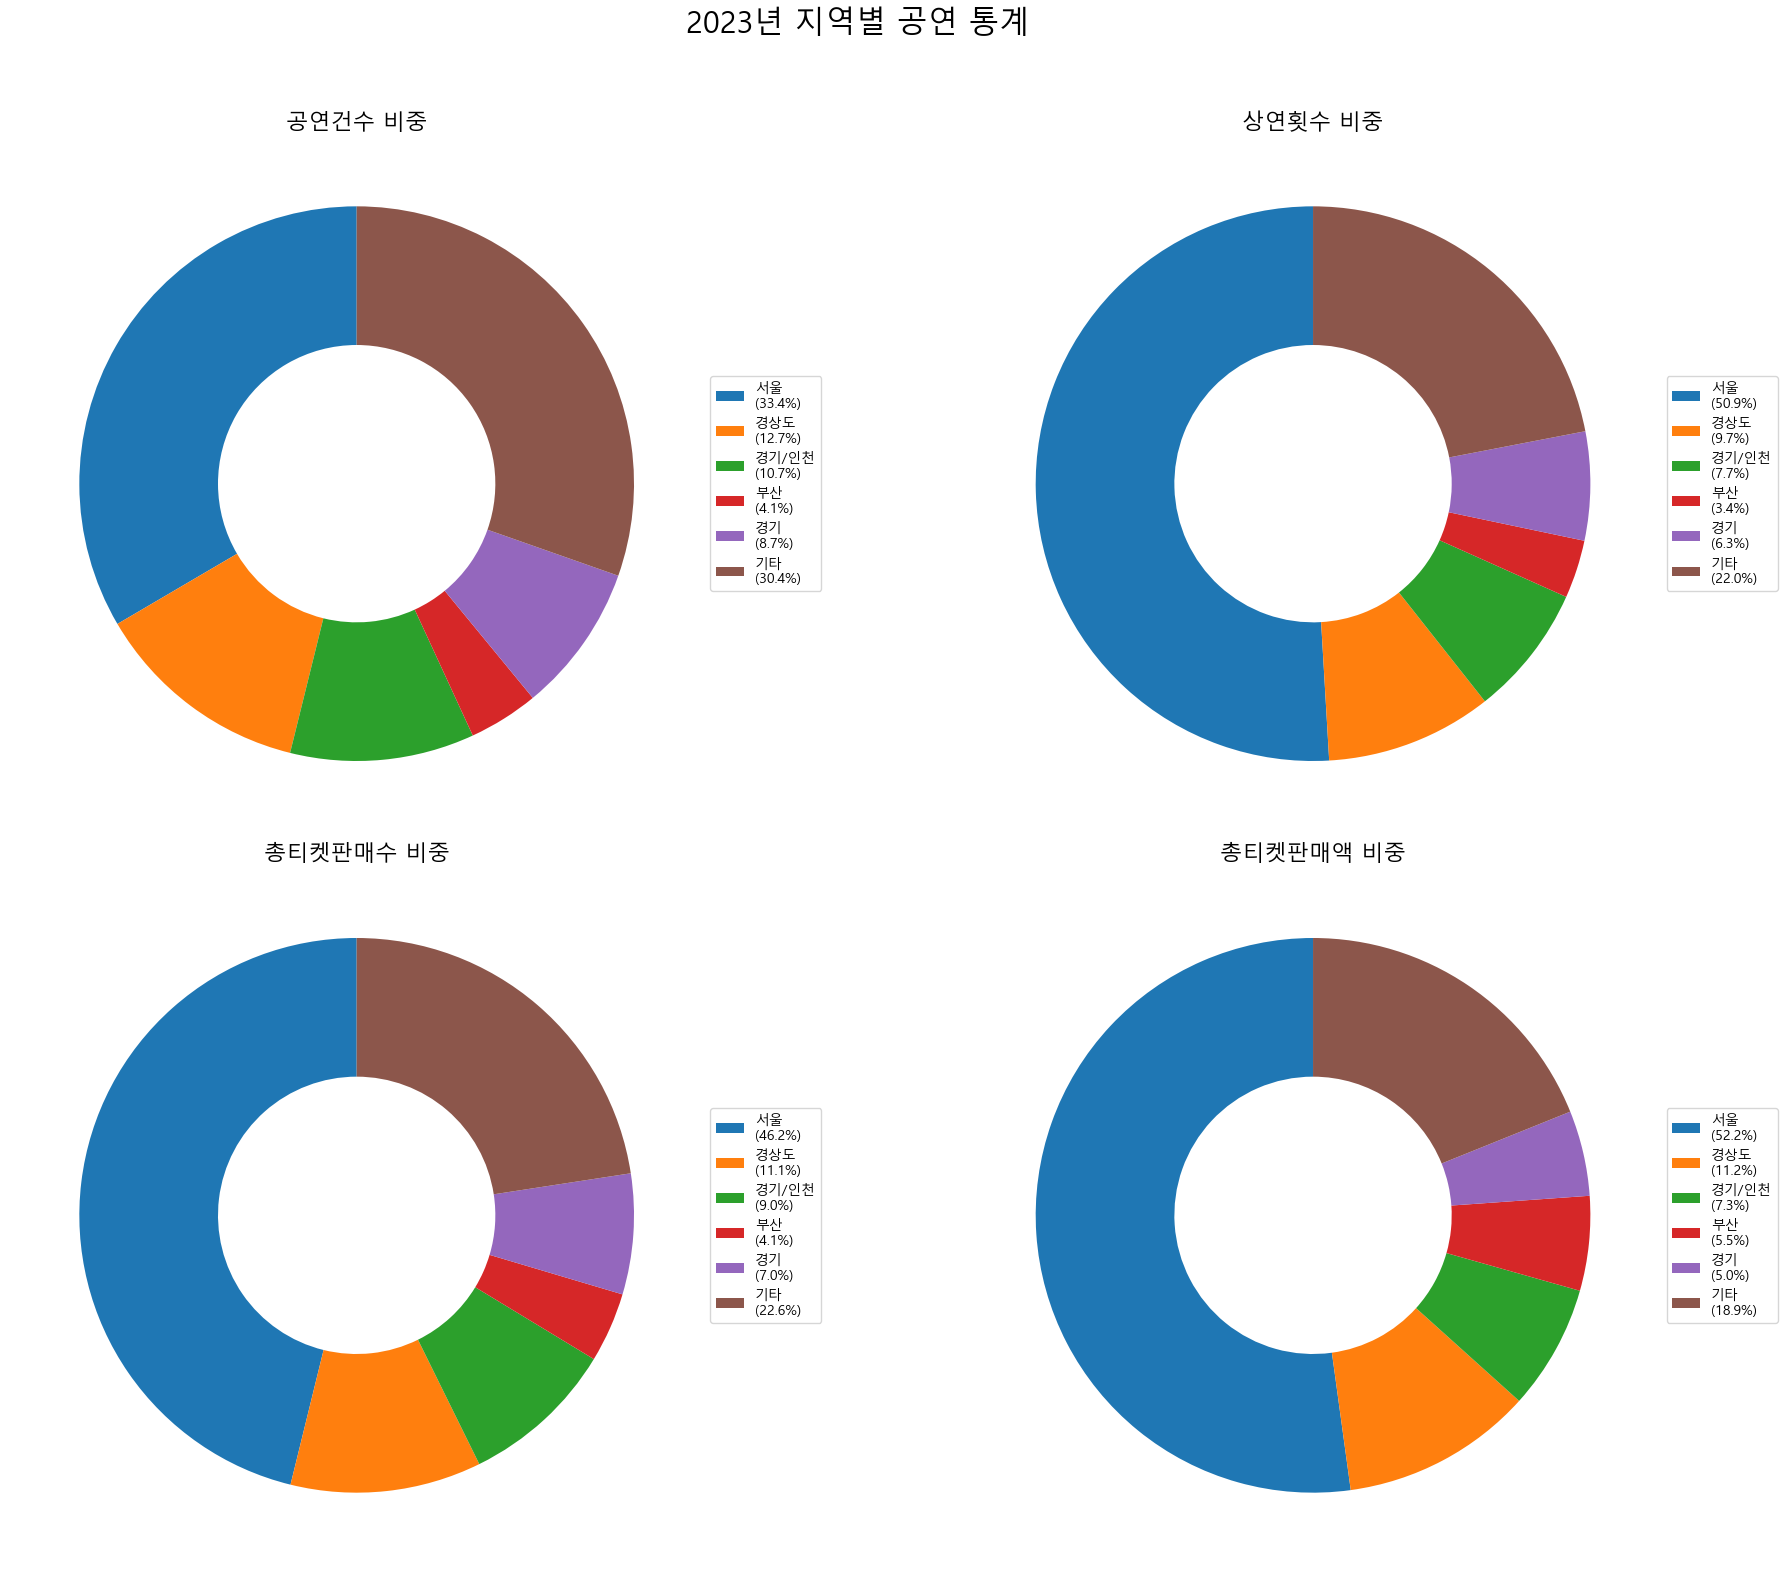

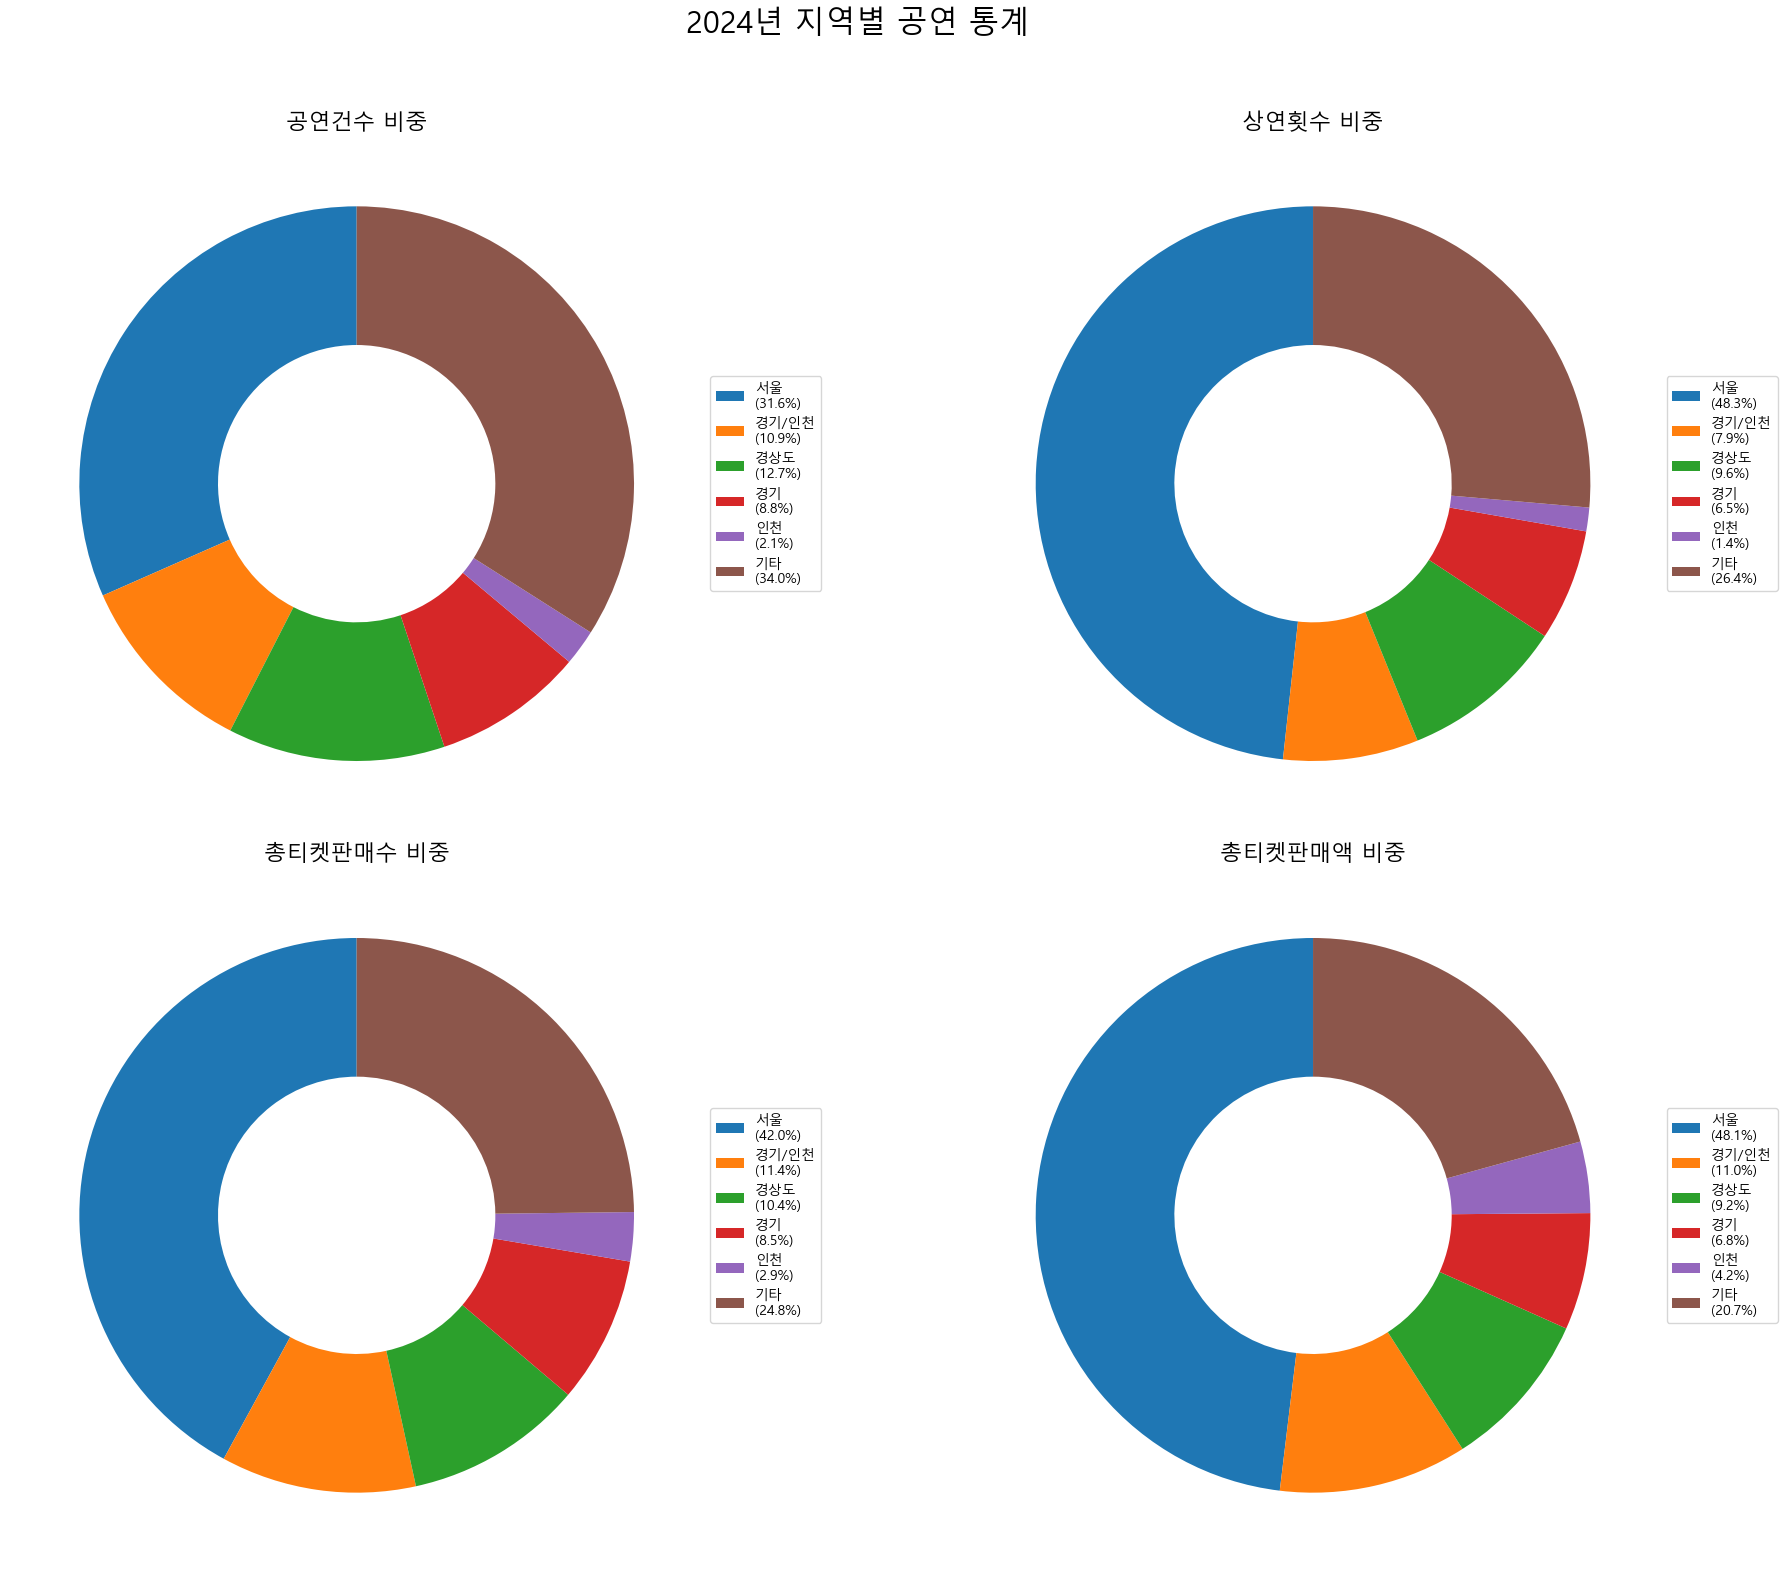

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import io
import numpy as np

# 맑은 고딕 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# CSV 파일 경로 (실제 경로로 변경 필요)
file_path = "kopis-data-collector-main/data_date_range/지역별 통계_20230101~20241231.csv"

# CSV 파일 읽기
df = pd.read_csv(file_path, encoding='utf-8')

# 합계 행만 찾기
summary_rows = df[df['지역명'] == '합계']

# 2023년과 2024년 데이터 분리 (처음 12개는 2023년, 나머지는 2024년)
summary_2023 = summary_rows.iloc[:12]
summary_2024 = summary_rows.iloc[12:21]  # 2024년은 9개월(1-9월) 데이터로 가정

# 지역별 그룹화를 위한 함수
def group_regions(df_period):
    # 지역별 그룹화 (합계 행 제외)
    regions_data = df_period[df_period['지역명'] != '합계']
    
    # 상위 5개 지역 찾기 (총티켓판매액 기준)
    top5_regions = regions_data.groupby('지역명')['총티켓판매액'].sum().nlargest(5).index.tolist()
    
    # 그룹화된 데이터 준비
    grouped_data = {}
    
    for metric in ['공연건수', '상연횟수', '총티켓판매수', '총티켓판매액']:
        metric_by_region = regions_data.groupby('지역명')[metric].sum()
        
        # 상위 5개 지역과 기타 지역으로 분류
        top5_data = {region: metric_by_region.get(region, 0) for region in top5_regions}
        other_sum = metric_by_region.sum() - sum(top5_data.values())
        
        # 결과 저장
        result = {**top5_data, '기타': other_sum}
        grouped_data[metric] = result
    
    return grouped_data, top5_regions

# 2023년과 2024년 데이터 그룹화
grouped_2023, top5_2023 = group_regions(df.iloc[:12 * len(df) // 21])
grouped_2024, top5_2024 = group_regions(df.iloc[12 * len(df) // 21:])

# 파이 차트 생성 함수
def create_pie_charts(grouped_data, year):
    metrics = ['공연건수', '상연횟수', '총티켓판매수', '총티켓판매액']
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'{year}년 지역별 공연 통계', fontsize=22)
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        data = grouped_data[metric]
        
        # 데이터 값과 레이블 준비
        values = list(data.values())
        labels = list(data.keys())
        
        # 비율 계산
        total = sum(values)
        percentages = [val/total*100 for val in values]
        
        # 레이블에 비율 추가
        labels_with_pct = [f'{label}\n({pct:.1f}%)' for label, pct in zip(labels, percentages)]
        
        # 파이 차트 생성
        wedges, texts = ax.pie(values, 
                              wedgeprops={'width': 0.5},
                              startangle=90)
        
        # 범례 설정
        ax.legend(wedges, labels_with_pct, 
                 loc="center left", 
                 bbox_to_anchor=(1, 0, 0.5, 1))
        
        # 제목 설정
        ax.set_title(f'{metric} 비중', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

# 파이 차트 생성
fig_2023 = create_pie_charts(grouped_2023, '2023')
fig_2024 = create_pie_charts(grouped_2024, '2024')

# 저장
fig_2023.savefig('2023년_지역별_공연통계.png', dpi=300, bbox_inches='tight')
fig_2024.savefig('2024년_지역별_공연통계.png', dpi=300, bbox_inches='tight')

plt.show()